# Segmentez des clients d'un site e-commerce
## Notebook 2 : Analyse exploratoire et premier feature ingineering
OpenClassrooms - Parcours Data Scientist - Projet 05  

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonction

**Analyse exploratoire**
* Schéma relationnel   
* Analyses univariées

**Premier feature engineering**
 


# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc5


## 1.2 Import des modules

In [2]:
# Installation des librairies
!pip install ipython-sql --quiet
!pip install pandas --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet

In [3]:
# Import des modules
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

## 1.3 Fonctions

In [4]:
# Renvoit le résultat d'une requête SQL
def query_result(query: str, all_rows: bool=True):
    with sqlite3.connect('olist.db') as conn:
        cursor = conn.cursor()
        cursor.execute(query)
        if all_rows:
            result = cursor.fetchall()
        else:
            result = cursor.fetchone()
            if len(result) == 1:
                result = result[0]
    return result

In [5]:
# Renvoit le résultat d'une requête SQL sous forme de dataframe
def f_query_result(query: str):
    with sqlite3.connect('olist.db') as conn:
        df = pd.read_sql_query(query, conn)
    return df

In [6]:
# Description des champs d'une table (à base de requêtes SQL)
def describe_table(table_name: str, fields=None):
    # Préparation des colonnes du dataframe de descriptions
    df_names, df_types, df_unique_values, df_duplicates, df_missing_values, df_percentage_missing = [], [], [], [], [], []
    
    # Récupération de la liste des champs de la table
    pragma = query_result(f"PRAGMA table_info({table_name});")
    table_fields = [row[1] for row in pragma]

    # Constitution de la liste des champs à décrire
    if fields is None:
        fields = [field for field in table_fields if field != 'index']
    elif isinstance(fields, str):
        fields = [fields]
        
    # Récupération/calculs des informations descriptives
    total_rows = query_result(f"SELECT COUNT(*) FROM {table_name};", False)
    for field_index, field_name in enumerate(table_fields):
        if field_name in fields:
            field_type = pragma[field_index][2]
            unique_values = query_result(f"SELECT COUNT(DISTINCT {field_name}) FROM {table_name};", False)
            non_null_values = query_result(f"SELECT COUNT({field_name}) FROM {table_name};", False)
            duplicates = non_null_values - unique_values
            missing_values = total_rows - non_null_values
            percentage_missing = (missing_values / total_rows) * 100 if total_rows > 0 else 0
            percentage_missing = str(round(percentage_missing, 2)) + ' %'

            df_names.append(field_name)
            df_types.append(field_type)
            df_unique_values.append(unique_values)
            df_duplicates.append(duplicates)
            df_missing_values.append(missing_values)
            df_percentage_missing.append(percentage_missing)

    # Céation du dataframe de description
    df_infos = pd.DataFrame({
        'Colonne': df_names,
        'Type': df_types,
        'Valeurs uniques': df_unique_values,
        'Doublons': df_duplicates,
        'Valeurs manquantes': df_missing_values,
        '% valeurs manquantes': df_percentage_missing
    }).reset_index(drop=True)

    return df_infos

In [7]:
# Description des varaibles d'un dataframe
def get_dataframe_infos(df):
    '''
    Examine le dataframe (ou la series) 'df' fourni en paramètre et renvoit un dataframe 'df_infos' composé des variables :
    - 'Colonne' : nom des variables de df
    - 'Type' : type de la colonne
    - 'Valeurs uniques' : nombre de valeurs unique de la colonne
    - 'Valeurs manquantes' : nombre de valeurs manquantes de la colonne
    - '% valeurs manquantes' : pourcentage de valeurs manquantes de la colonne
    - 'Doublons' : nombre de valeurs non uniques (doublons) de la colonne
    '''
    if isinstance(df, pd.Series):
        df = df.to_frame()
    number_of_rows = df.shape[0]
    col_names = df.columns
    col_types = df.dtypes
    unique_values = df.nunique()
    missing_values = df.isnull().sum()
    non_missing_values = number_of_rows - missing_values
    duplicate_values = non_missing_values - unique_values

    df_infos = pd.DataFrame({
        'Colonne': col_names,
        'Type': col_types,
        'Valeurs uniques': unique_values,
        'Doublons': duplicate_values,
        'Valeurs manquantes': missing_values,
        '% valeurs manquantes': round((missing_values / number_of_rows) * 100, 2).astype(str) + " %"
    }).reset_index(drop=True)

    return df_infos

In [8]:
# Transforme les types des variables d'un dataframe
def transform_data_types(df, transformations):
    # Conversion en type string ou category si le nbre de valeurs uniques est faible
    if 'to_string' in transformations:
        for column in transformations['to_string']:
            if df[column].nunique() / len(df[column]) < 0.02:
                df[column] = df[column].astype('category')
            else:
                df[column] = df[column].astype(str)
            df[column] = df[column].replace('None', np.nan)
    
    # Conversion en dates avec gestion NaT
    if 'to_date' in transformations:
        if len(df[transformations['to_date']].iloc[0]) <= 10 :
            for column in transformations['to_date']:
                df[column] = pd.to_datetime(df[column], errors='coerce')
        else:
            for column in transformations['to_date']:
                df[column] = pd.to_datetime(df[column], errors='coerce').dt.round('s')
   
    # Conversion en entier avec gestion NaN
    if 'to_integer' in transformations:
        for col in transformations['to_integer']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    # Conversion en flottants
    if 'to_float' in transformations:
        for col in transformations['to_float']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    
    return df

In [9]:
# Affiche l'histogramme et le boxplot d'une feature
def plot_distribution(dataframe, feature, x_label, y_label, x_tick_angle=None):
    fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    plt.subplots_adjust(hspace=0.05)  # Ajuste l'espace entre les graphiques
    
    # Histogramme
    sns.histplot(dataframe[feature], bins=50, kde=True, ax=axs[0])
    axs[0].set_title(f'Distribution {feature}', pad=10)
    axs[0].set_xlabel('')  # Supprime le label de l'axe x pour l'histogramme
    axs[0].set_ylabel(y_label)
    axs[0].grid(linewidth=0.25)
    
    # Boxplot
    sns.boxplot(x=dataframe[feature], ax=axs[1])
    axs[1].set_xlabel(x_label)
    axs[1].set_yticks([])  # Supprime les ticks de l'axe y pour le boxplot

    if x_tick_angle is not None:
        for axis in axs:
            for label in axis.get_xticklabels():
                label.set_rotation(x_tick_angle)

    plt.show()

# 2 Analyse exploratoire

## 2.1 Schéma relationnel

![shema relationnel](schema_relationnel_olist.png "Shéma relationnel BDD olist")

L'objectif est de réaliser une **segmentation des clients**.  
Je vais donc porter une attention particulière sur les champs me permettant de calculer des scores par client :  
* **Récence** : date de la dernière commande => `orders.order_approved_at` ?  
* **Fréquence** : nombre total de commandes => `customers.customer_id`, `orders.order_id` ou `orders.customer_id` ?  
* **Montant** : valeur totale des achats => `order_items.price` (+ `order_items.freight` ?), `order_pymts.payment_value` ?  
* **Panier moyen** : valeur moyenne d'une commande => Montant total / nombre de commandes  
* **Score de satisfaction** : notes de satisfaction => `order_reviews.review_score` (comment compléter les manquants : KNN ?)
* **Motif d'insatisfation** ??? Si pertinent, comment obtenir cette info ? 
* **Délai de livraison** : `orders.order_delivered_customer_date` - `orders.order_purchase_timestamp` ? `orders.order_delivered_customer_date` - `orders.order_approved_at` ?
* **Retard de livraison** : `orders.order_delivered_customer_date` - `orders.estimated_delivery_date`
* **Situation géographique du client** ??? Y aurait-il des différences selon les régions ?
* **Distance par rapport au vendeur** ??? Si pertinent comment gérer les commandes regroupant plusieurs vendeurs ? La moyenne des distances serait pertinente ?
* **Échelonnement** : nombre moyen d'échéances pour payer une commande => `order_pymts.payment_installments` / nombre de commandes : pertinent ???

## 2.2 Analyses univariées

* Utilisation des fonctions :
   * `describe_table('nom_table')` : récupère et calcule le nom des champs, leur type, le nombre de valeurs uniques, de doublons, de valeurs manquantes directement sur la table, en SQL, puis renvoie un dataframe
   * `f_query_result('query')` : exécute une requête SQL et renvoie un dataframe
   * `get_df_infos(dataframe)` : renvoie un dataframe avec les mêmes informations que `describe_table()`, mais calculées en python à partir d'un dataframe
* Toutes les tables de la BDD contiennent un champ `index` qui sera supprimé à chaque récupération sous forme de dataframe, pour ne pas faire double-emploi

### 2.2.1 Table `orders`

In [10]:
# Récupération de tout le contenu de la table dans un dataframe
df_orders = f_query_result("SELECT * FROM orders;").drop('index', axis=1)

In [11]:
# Affichage de quelques lignes
display(df_orders)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [12]:
# Description des champs de la table
display(describe_table('orders'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,TEXT,99441,0,0,0.0 %
1,customer_id,TEXT,99441,0,0,0.0 %
2,order_status,TEXT,8,99433,0,0.0 %
3,order_purchase_timestamp,TEXT,98875,566,0,0.0 %
4,order_approved_at,TEXT,90733,8548,160,0.16 %
5,order_delivered_carrier_date,TEXT,81018,16640,1783,1.79 %
6,order_delivered_customer_date,TEXT,95664,812,2965,2.98 %
7,order_estimated_delivery_date,TEXT,459,98982,0,0.0 %


In [13]:
# Description des variables du dataframe
display(get_dataframe_infos(df_orders))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,99441,0,0,0.0 %
1,customer_id,object,99441,0,0,0.0 %
2,order_status,object,8,99433,0,0.0 %
3,order_purchase_timestamp,object,98875,566,0,0.0 %
4,order_approved_at,object,90733,8548,160,0.16 %
5,order_delivered_carrier_date,object,81018,16640,1783,1.79 %
6,order_delivered_customer_date,object,95664,812,2965,2.98 %
7,order_estimated_delivery_date,object,459,98982,0,0.0 %


* Hormis les types, les informations relevées sont strictement identiques👍🏼
* Toutes les colonnes de la table sont de type `TEXT`, et transformées en type `OBJECT` via l'import en dataframe
* Les variables doivent être converties dans les bons types

In [14]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['order_id', 'customer_id', 'order_status'],
    'to_date': ['order_purchase_timestamp',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date']
}

# Conversions
df_orders = transform_data_types(df_orders, to_transform)

* Verification des transformations

In [15]:
# Description des variables du dataframe
display(get_dataframe_infos(df_orders))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,99441,0,0,0.0 %
1,customer_id,object,99441,0,0,0.0 %
2,order_status,category,8,99433,0,0.0 %
3,order_purchase_timestamp,datetime64[ns],98875,566,0,0.0 %
4,order_approved_at,datetime64[ns],90733,8548,160,0.16 %
5,order_delivered_carrier_date,datetime64[ns],81018,16640,1783,1.79 %
6,order_delivered_customer_date,datetime64[ns],95664,812,2965,2.98 %
7,order_estimated_delivery_date,datetime64[ns],459,98982,0,0.0 %


In [16]:
# Principales mesures statistiques
df_orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99281,97658,96476,99441
mean,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


#### 2.2.1.1 `order_status`

* Valeurs uniques

In [17]:
df_order_status = df_orders['order_status'].value_counts().to_frame()
no_orders = df_orders.shape[0]
df_order_status['%'] = round((df_order_status['count'] / no_orders) * 100, 2).astype(str) + ' %'
display(df_order_status)

,count,%
order_status,,
delivered,96478,97.02 %
shipped,1107,1.11 %
canceled,625,0.63 %
unavailable,609,0.61 %
invoiced,314,0.32 %
processing,301,0.3 %
created,5,0.01 %
approved,2,0.0 %


* La très grande majorité des commandes ont le statut 'delivered' ($97.02 \%$)  
* Les commandes avec un statut différent pourront être supprimées :
   * Représentant moins de $3 \%$ des commandes, sans elles les résultats ne seront pas impactés
   * N'étant pas livrées, ces commandes n'auront pas de review, on ne pourra pas calculer le délai de livraison...

In [18]:
# Suppression des commandes non livrées
mask = df_orders['order_status'] != 'delivered'
df_orders = df_orders.loc[~mask]

* La variable `order_status` n'a plus d'intérêt

In [19]:
# Suppression de la variable 'order_status'
df_orders = df_orders.drop('order_status', axis=1)

#### 2.2.1.2 `order_purchase_timestamp`, `order_approved_at`, `order_delivered_carrier_date`, `order_delivered_customer_date`, `order_estimated_delivery_date`

In [20]:
date_fields = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

In [21]:
display(get_dataframe_infos(df_orders[date_fields]))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_purchase_timestamp,datetime64[ns],95956,522,0,0.0 %
1,order_approved_at,datetime64[ns],88274,8190,14,0.01 %
2,order_delivered_carrier_date,datetime64[ns],80106,16370,2,0.0 %
3,order_delivered_customer_date,datetime64[ns],95658,812,8,0.01 %
4,order_estimated_delivery_date,datetime64[ns],445,96033,0,0.0 %


* Quelles sont les commandes sans date d'approbation ?

In [22]:
wo_approbation_mask = df_orders['order_approved_at'].isna()
display(df_orders.loc[wo_approbation_mask])

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


In [23]:
# Date des première et dernière commandes sans dates d'approbation
wo_approbation_start_date = df_orders.loc[wo_approbation_mask, 'order_purchase_timestamp'].min()
wo_approbation_end_date = df_orders.loc[wo_approbation_mask, 'order_purchase_timestamp'].max()
display(wo_approbation_start_date)
display(wo_approbation_end_date)

Timestamp('2017-01-19 12:48:08')

Timestamp('2017-02-19 01:28:47')

* Il semblerait qu'il y ait eu un souci sur une période d'un mois, entre les 19 janvier et 19 février 2017
* Stratégie pour remplacer ces valeurs manquantes :
   * Calculer le délai moyen entre la date de validation du paiement `order_approved_at` et la date de dépôt au livreur `order_delivered_carrier_at`
   * Si ce délai est relativement constant sur une courte période avant et après la période problématique, l'appliquer en s'assurant que la date calculée ne soit pas antérieure à la date d'achat `order_approved_at`

In [24]:
# Affichage de toutes les commandes de la période 

In [25]:
period_mask = (df_orders['order_purchase_timestamp'] >= wo_approbation_start_date) & \
              (df_orders['order_purchase_timestamp'] <= wo_approbation_end_date)
df_orders.loc[period_mask]

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06
106,a6cd683d4bd3b9b1f0aa37b27f8116d3,48f239e15744ed5e7ffbafc6bb6e882b,2017-01-28 23:45:53,2017-01-29 01:31:48,2017-02-01 14:25:06,2017-02-10 17:30:19,2017-03-10
251,bb4f0c21ae6014e40ef007ff6fbcbeb9,94f7f1cb719dd707fd437e918d282537,2017-02-12 18:48:56,2017-02-12 19:02:52,2017-02-16 14:42:05,2017-03-01 14:09:10,2017-03-16
258,51fc12a7908ea200b269a6ecfb3e7740,abbfa19a38ba17ff02883ba523a9d42f,2017-02-08 18:00:36,2017-02-10 02:55:28,2017-02-15 12:37:51,2017-02-20 18:14:01,2017-03-17
303,bd2623f3663c5daa3f89e6b527fd49da,b7b15ab12fa50616eee696a22f098e07,2017-01-21 17:08:01,2017-01-21 17:22:49,2017-01-24 07:47:47,2017-01-27 18:12:13,2017-03-02
...,...,...,...,...,...,...,...
99156,d84b3fdfbb838b26178304662ff635e1,aa90812c60112bac39cefe1f2ed45d84,2017-02-05 18:54:57,2017-02-05 19:05:16,2017-02-07 07:28:05,2017-02-10 12:03:38,2017-03-06
99180,469f0b908881368c45917f1bed8240ce,59e4d7310198da197337571749b47ff2,2017-01-24 21:35:25,2017-01-25 16:30:14,2017-01-26 06:32:47,2017-02-08 08:14:01,2017-03-23
99190,7a9f31f6c0e36f4e6fb8d27c49c18fd6,4db09730e85cacf07aa9c7ce98ee2a16,2017-02-18 12:27:48,2017-02-18 13:05:49,2017-02-20 12:32:42,2017-03-16 09:28:00,2017-03-31
99329,9058bc799c3791077efb3aaa8e0d5e02,3fb83e207757e8f15ff70d937c86929b,2017-01-24 09:24:11,2017-01-25 02:45:13,2017-01-25 13:20:38,2017-01-30 09:39:02,2017-03-01


* 1720 commandes de cette même période ne sont pas concernées par le problème  
* Le délai moyen sera calculé sur cette période

In [26]:
# Dates de début et de fin
start_date = df_orders.loc[mask, 'order_purchase_timestamp'].min()
end_date = df_orders.loc[mask, 'order_purchase_timestamp'].max()

In [27]:
# Création d'une colonne contenant le délai en heures entre la date d'approbation et la date de dépôt au livreur
df_orders['approval_delay'] = (df_orders['order_delivered_carrier_date'] - df_orders['order_approved_at']).dt.total_seconds() / 3600

# Calculer le délai moyen en heures
average_delay_hours = df_orders.loc[period_mask, 'approval_delay'].mean()

print(f"Le délai moyen de mise en livraison est de {average_delay_hours} heures.")

Le délai moyen de mise en livraison est de 71.82518040901394 heures.


In [28]:
# Affichage des statistiques
df_orders.loc[period_mask, 'approval_delay'].to_frame().describe()

,approval_delay
count,1706.000000
mean,71.825180
std,106.525119
min,-162.771389
25%,17.254236
50%,41.064028
75%,83.612847
max,1317.925000


* Avec délai minimum de **-163 heures**, un maximum de **1 318 heures** et un écart-type de **107 heures**, prendre une valeur moyenne n'aurait aucun sens  
*(Y-a-t-il des commandes qui sont mises en livraison avant validation du paiement ?)*

* Le délai entre la validation du paiement et la mise en livraison est-il plus stable ?

In [29]:
# Création d'une colonne contenant le délai en heures entre la date d'achat et la date de validation du paiement
df_orders['shipping_preparation_delay'] = (df_orders['order_approved_at'] - df_orders['order_purchase_timestamp']).dt.total_seconds() / 3600

# Calculer le délai moyen en heures
average_delay_hours = df_orders.loc[period_mask, 'shipping_preparation_delay'].mean()

print(f"Le délai moyen de validation du paiement est de {average_delay_hours} heures.")

Le délai moyen de validation du paiement est de 9.377638888888889 heures.


In [30]:
# Affichage des statistiques
df_orders.loc[period_mask, 'shipping_preparation_delay'].to_frame().describe()

,shipping_preparation_delay
count,1706.000000
mean,9.377639
std,19.674242
min,0.095000
25%,0.185556
50%,0.240556
75%,12.519167
max,267.106389


* Avec délai minimum de **quelques minutes**, un maximum de **267 heures** et un écart-type de **21 heures**, prendre une valeur moyenne n'aurait pas plus de sens

* Abandon de la tentative de correction des valeurs manquantes, et suppression des 14 commandes concernées (0.01 % du nombre total de commandes)

In [31]:
# Suppression des commandes sans `order_approved_date`
df_orders = df_orders.loc[~wo_approbation_mask]

In [32]:
# Mise à jour des infos
display(get_dataframe_infos(df_orders[date_fields]))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_purchase_timestamp,datetime64[ns],95942,522,0,0.0 %
1,order_approved_at,datetime64[ns],88274,8190,0,0.0 %
2,order_delivered_carrier_date,datetime64[ns],80094,16368,2,0.0 %
3,order_delivered_customer_date,datetime64[ns],95644,812,8,0.01 %
4,order_estimated_delivery_date,datetime64[ns],445,96019,0,0.0 %


* Suppression des 2 commandes sans date de mise en livraison  
* Suppression des 8 commandes non encore livrées

In [33]:
# Suppression
mask = (df_orders['order_delivered_carrier_date'].isna()) | (df_orders['order_delivered_customer_date'].isna())
df_orders = df_orders.loc[~mask]

* Graphiques des distributions

In [34]:
date_fields = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

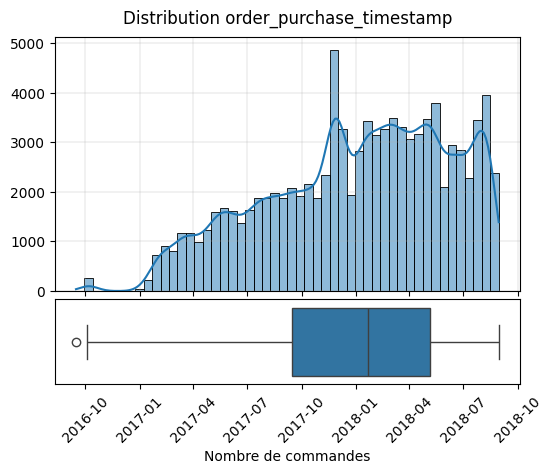

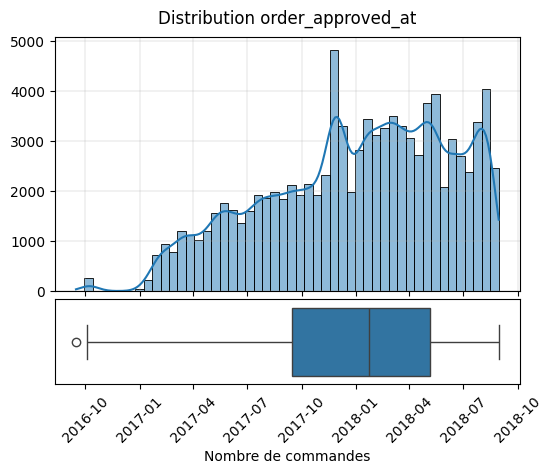

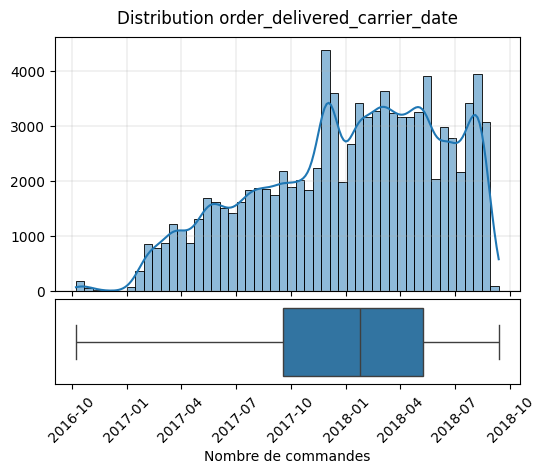

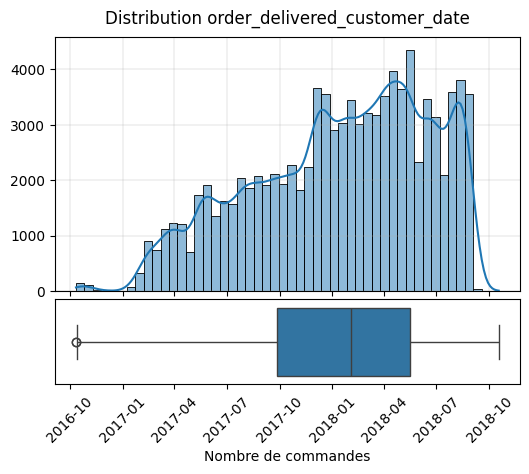

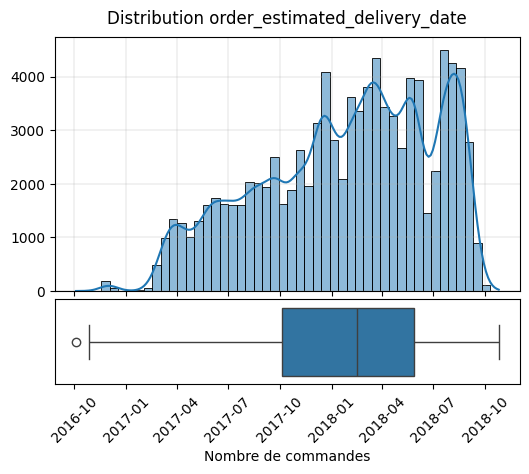

In [35]:
for feature in date_fields:
    plot_distribution(df_orders, feature, 'Nombre de commandes', '', x_tick_angle=45)
    print()

* Les répartitions des distributions se ressemblent fortement, il est probable que ces variables soient fortement corrélées entre elles.
* Ce serait logique puisque ces dates correspondent à des événement qui s'enchaînent (achat -> validation du paiement -> mise en livraison...)

### 2.2.2 Table `order_items`

In [36]:
# Récupération de tout le contenu de la table dans un dataframe
df_order_items = f_query_result("SELECT * FROM order_items;").drop('index', axis=1)

In [37]:
# Affichage de quelques lignes
display(df_order_items)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [38]:
# Description des champs de la table
display(describe_table('order_items'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,TEXT,98666,13984,0,0.0 %
1,order_item_id,BIGINT,21,112629,0,0.0 %
2,product_id,TEXT,32951,79699,0,0.0 %
3,seller_id,TEXT,3095,109555,0,0.0 %
4,shipping_limit_date,TEXT,93318,19332,0,0.0 %
5,price,FLOAT,5968,106682,0,0.0 %
6,freight_value,FLOAT,6999,105651,0,0.0 %


In [39]:
# Description des variables du dataframe
display(get_dataframe_infos(df_order_items))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,98666,13984,0,0.0 %
1,order_item_id,int64,21,112629,0,0.0 %
2,product_id,object,32951,79699,0,0.0 %
3,seller_id,object,3095,109555,0,0.0 %
4,shipping_limit_date,object,93318,19332,0,0.0 %
5,price,float64,5968,106682,0,0.0 %
6,freight_value,float64,6999,105651,0,0.0 %


* Hormis les types, les informations relevées sont strictement identiques👍🏼
* Aucune valeur n'est manquante
* Les variables `order_id`, `product_id`, `seller_id` et `shipping_limit_date` doivent être converties dans les bons types
* Les lignes de commandes correspondant aux commandes supprimées dans la table `orders`, doivent être aussi supprimées

In [40]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['order_id', 'product_id', 'seller_id'],
    'to_date': ['shipping_limit_date']
}

# Conversions
df_order_items = transform_data_types(df_order_items, to_transform)

* Vérification des transformations

In [41]:
display(get_dataframe_infos(df_order_items))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,98666,13984,0,0.0 %
1,order_item_id,int64,21,112629,0,0.0 %
2,product_id,object,32951,79699,0,0.0 %
3,seller_id,object,3095,109555,0,0.0 %
4,shipping_limit_date,datetime64[ns],93318,19332,0,0.0 %
5,price,float64,5968,106682,0,0.0 %
6,freight_value,float64,6999,105651,0,0.0 %


* Suppression des lignes de commandes sans commande

In [42]:
# Récupération des 'order_id' de la table 'orders'
valid_order_ids = df_orders['order_id'].unique()

In [43]:
# Filtre sur les 'order_id' valides
valid_orders_mask = df_order_items['order_id'].isin(valid_order_ids)

In [44]:
# Suppression des lignes de 'df_order_items' ne correspondant pas à une commande valide dans 'df_orders'
df_order_items = df_order_items.loc[valid_orders_mask]

* Mise à jour de la descriptions des variables

In [45]:
# Description des variables du dataframe
display(get_dataframe_infos(df_order_items))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,96455,13718,0,0.0 %
1,order_item_id,int64,21,110152,0,0.0 %
2,product_id,object,32210,77963,0,0.0 %
3,seller_id,object,2970,107203,0,0.0 %
4,shipping_limit_date,datetime64[ns],91321,18852,0,0.0 %
5,price,float64,5859,104314,0,0.0 %
6,freight_value,float64,6924,103249,0,0.0 %


In [46]:
# Principales mesures statistiques
df_order_items.describe()

,order_item_id,shipping_limit_date,price,freight_value
count,110173.000000,110173,110173.000000,110173.000000
mean,1.198216,2018-01-08 18:12:57.306299904,119.978575,19.949051
min,1.000000,2016-09-19 23:11:33,0.850000,0.000000
25%,1.000000,2017-09-21 15:10:11,39.900000,13.080000
50%,1.000000,2018-01-26 20:37:29,74.900000,16.260000
75%,1.000000,2018-05-10 20:30:37,134.170000,21.150000
max,21.000000,2020-04-09 22:35:08,6735.000000,409.680000
std,0.706743,NaN,182.314081,15.699528


#### 2.2.2.1 `order_item_id`

Cette variable représente le numéro de séquence des produits d'une une commande  
Si un même produit est vendu 2 fois dans une même commande, on aura 2 lignes pour ce produit dans `order_items`, avec `order_item_id` allant de 1 à 2  
* Exemple :  

In [47]:
# Récupération d'une commande contenant 3 unités, avec au moins 2 produits différents
mask = df_order_items['order_item_id'] == 3
three_units_order_id = df_order_items.loc[mask, 'order_id'].to_list()[3]

# Affichage des produits de la commande
mask = df_order_items['order_id'] == three_units_order_id
df_order_items.loc[mask]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
151,005d9a5423d47281ac463a968b3936fb,1,fb7a100ec8c7b34f60cec22b1a9a10e0,d98eec89afa3380e14463da2aabaea72,2017-10-24 12:28:16,49.99,18.12
152,005d9a5423d47281ac463a968b3936fb,2,4c3ae5db49258df0784827bdacf3b396,d98eec89afa3380e14463da2aabaea72,2017-10-24 12:28:16,24.99,13.58
153,005d9a5423d47281ac463a968b3936fb,3,4c3ae5db49258df0784827bdacf3b396,d98eec89afa3380e14463da2aabaea72,2017-10-24 12:28:16,24.99,13.58


* Création d'un dataframe regroupant les informations suivantes :
   * `order_id`  
   * `product_id`
   * max(`order_item_id`) : donnera le nombre d'unités achetées du produit
   * sum(`price`) : prix total du produit X quantité achetée  
   * sum(`freight`) : frais de transport X quantité achetée

In [48]:
# Création dataframe 'df_order_products'
df_order_products = df_order_items.groupby(['order_id', 'product_id']).agg(
    total_units = ('order_item_id', 'count'),  # Nombre total d'unités achetées pour chaque produit
    total_price = ('price', 'sum'),          # Prix total pour chaque produit
    total_freight = ('freight_value', 'sum') # Frais de transport total pour chaque produit
).reset_index()

In [49]:
# Affichage pour vérification
display(df_order_products)

,order_id,product_id,total_units,total_price,total_freight
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,1,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,1,199.90,18.14
...,...,...,...,...,...
100168,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,1,299.99,43.41
100169,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,1,350.00,36.53
100170,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,1,99.90,16.95
100171,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,1,55.99,8.72


In [50]:
# Affichage de la commande prise en exemple
mask = df_order_products['order_id'] == three_units_order_id
df_order_products.loc[mask]

,order_id,product_id,total_units,total_price,total_freight
134,005d9a5423d47281ac463a968b3936fb,4c3ae5db49258df0784827bdacf3b396,2,49.98,27.16
135,005d9a5423d47281ac463a968b3936fb,fb7a100ec8c7b34f60cec22b1a9a10e0,1,49.99,18.12


* Combien de produits différents sont achetés par commande ?
* Combien d'unités totales de produits sont achetés par commande ?

In [51]:
# Dataframe d'aggrégation
df_order_summary = df_order_products.groupby('order_id').agg(
    number_of_product_ids = ('product_id', 'nunique'),  # Compte le nombre unique de product_id par commande
    number_of_total_units = ('total_units', 'sum'),     # Somme toutes les unités pour chaque commande
    total_price = ('total_price', 'sum'),               # Montant total de la commande, hors frais de livraison
    total_freight = ('total_freight', 'sum')            # Montant total des frais de livraison
).reset_index()

# Noms des features crées
df_order_summary.columns = ['order_id', 'number_of_product_ids', 'number_of_total_units', 'total_price', 'total_freight']

# Ajout du montant total de la commande
df_order_summary['total_order'] = df_order_summary['total_price'] + df_order_summary['total_freight']

In [52]:
# Afficher pour vérification
display(df_order_summary)

,order_id,number_of_product_ids,number_of_total_units,total_price,total_freight,total_order
0,00010242fe8c5a6d1ba2dd792cb16214,1,1,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,1,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,1,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,1,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,1,199.90,18.14,218.04
...,...,...,...,...,...,...
96450,fffc94f6ce00a00581880bf54a75a037,1,1,299.99,43.41,343.40
96451,fffcd46ef2263f404302a634eb57f7eb,1,1,350.00,36.53,386.53
96452,fffce4705a9662cd70adb13d4a31832d,1,1,99.90,16.95,116.85
96453,fffe18544ffabc95dfada21779c9644f,1,1,55.99,8.72,64.71


In [53]:
# Affichage de la commande prise en exemple
mask = df_order_summary['order_id'] == three_units_order_id
df_order_summary.loc[mask]

,order_id,number_of_product_ids,number_of_total_units,total_price,total_freight,total_order
132,005d9a5423d47281ac463a968b3936fb,2,3,99.97,45.28,145.25


* Nombres de produits achetés par commandes (1 produit = 1 `product_id`)

In [54]:
dft = df_order_summary['number_of_product_ids'].value_counts().to_frame()
dft.columns = ['number_of_orders']
number_of_products = df_order_summary['number_of_product_ids'].count()
dft['%'] = round((dft['number_of_orders'] / number_of_products) * 100, 3).astype(str) + ' %'
display(dft)

,number_of_orders,%
number_of_product_ids,,
1,93258,96.686 %
2,2808,2.911 %
3,298,0.309 %
4,69,0.072 %
6,10,0.01 %
5,8,0.008 %
7,3,0.003 %
8,1,0.001 %


* La grande majorité des commandes (environ **97 %**) contient **1 seul produit** (même s'il est acheté dans une quantité > 1)
* Seulement environ **2.9 %** des commandes contiennent **2 produits**
* **Moins de 0.5 %** des commandes incluent **3 produits ou plus**

* Nombres d'articles achetés par commandes (1 article = 1 unité, quelque soit le `product_id`)

In [55]:
dft = df_order_summary['number_of_total_units'].value_counts().to_frame()
dft.columns = ['number_of_orders']
number_of_units = df_order_summary['number_of_total_units'].count()
dft['%'] = round((dft['number_of_orders'] / number_of_units) * 100, 3).astype(str) + ' %'
display(dft.sort_values(by='number_of_total_units'))

,number_of_orders,%
number_of_total_units,,
1,86821,90.012 %
2,7391,7.663 %
3,1306,1.354 %
4,495,0.513 %
5,193,0.2 %
6,191,0.198 %
7,22,0.023 %
8,8,0.008 %
9,3,0.003 %


* La grande majorité des commandes (environ **90 %**) contient **1 seul articke**  
* Seulement environ **8 %** des commandes contiennent **2 articles** (2 produits différents ou un même produit acheté en quantité 2)  
* Environ **2.3 %** des commandes incluent **3 articles ou plus**

#### 2.2.2.2 `shipping_limit_date`

Date limite à laquelle le vendeur doit remettre la commande au partenaire logistique pour l'expédition

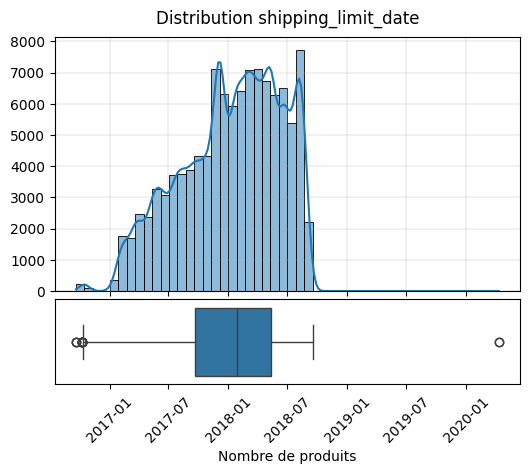

In [56]:
# Affichage de la distibution
plot_distribution(df_order_items, 'shipping_limit_date', 'Nombre de produits', '', x_tick_angle=45)

* Quelle est ce produit qui a une date limite de dépôt chez le livreur en 2020 ?

In [57]:
# Affichage dans `order_items`
mask = df_order_items['shipping_limit_date'] == df_order_items['shipping_limit_date'].max()
df_order_items.loc[mask]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
85729,c2bb89b5c1dd978d507284be78a04cb2,1,87b92e06b320e803d334ac23966c80b1,7a241947449cc45dbfda4f9d0798d9d0,2020-04-09 22:35:08,99.99,61.44
85730,c2bb89b5c1dd978d507284be78a04cb2,2,87b92e06b320e803d334ac23966c80b1,7a241947449cc45dbfda4f9d0798d9d0,2020-04-09 22:35:08,99.99,61.44


In [58]:
# Affichage dans `orders`
weird_product_order_id = df_order_items.loc[mask, 'order_id'].iloc[0]
wp_mask = df_orders['order_id'] == weird_product_order_id
df_orders.loc[wp_mask]

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,approval_delay,shipping_preparation_delay
86444,c2bb89b5c1dd978d507284be78a04cb2,6357fffb5704244d552615bbfcea1442,2017-05-23 22:28:36,2017-05-24 22:35:08,2017-05-29 02:03:28,2017-06-09 13:35:54,2017-10-11,99.472222,24.108889


* Cette commande a une `shipping_limit_date` à '2020-04-09 **22:35:08**' et un `order_purchase_timestamp` à '2017-05-24 **22:35:08**'
* On peut raisonnablement supposer qu'il s'agit d'une erreur de saisie dans la `shipping_limit_date` puisqu'en les heures sont identiques à la seconde près
* Ne corriger que l'année mettrait cependant une date d'achat au **24 mai 2017** pour une date limite d'expédition au **9 avril 2017**, ce qui serait incohérent
* Sans possibilité d'avoir plus d'information sur la réelle date limite d'expédition, suppression de la commande concernée

* Suppressions dans 'df_orders' et 'df_order_items'

In [59]:
# Suppression dans 'df_orders' et 'df_order_items'
df_orders = df_orders[df_orders['order_id'] != weird_product_order_id]
df_order_items = df_order_items[df_order_items['order_id'] != weird_product_order_id]

* Version SQL pour suppression dans les table, commentée volontairement, à mettre en oeuvre si :
   * le feature ingineering se fait en SQL  
   * après sauvegarde de la BDD

In [60]:
# Suppression des tables `orders` et `order_items`
# for table_name in ('orders', 'order_items'):
#     query = f"DELETE FROM {table_name} WHERE order_id = '{weid_product_order_id}';"
#     with sqlite3.connect('olist.db') as conn:
#         cursor = conn.cursor()
#         cursor.execute(query)

* Affichage de la distribution après correction

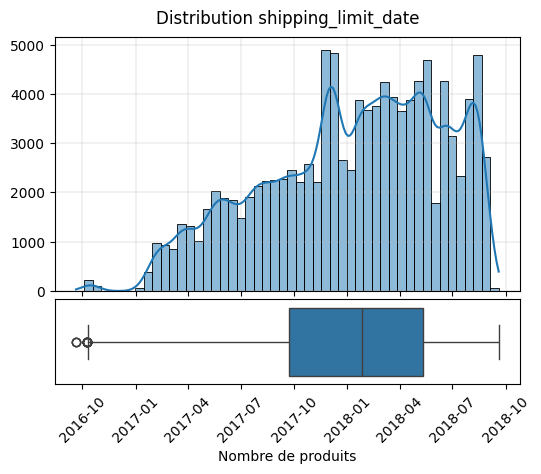

In [61]:
# Affichage de la distibution après correction
plot_distribution(df_order_items, 'shipping_limit_date', 'Nombre de produits', '', x_tick_angle=45)

* Cette distribution ressemble logiquement aux distributions des variables `order_purchase_timestamp`, `order_approved_at`, `order_delivered_carrier_date`, `order_delivered_customer_date` et `order_estimated_delivery_date` du dataframes `orders`

#### 2.2.2.3 `price`

Prix unitaire d'un produit

* Distribution
  * L'affichage de la distribution a peu de sens puisqu'un même produit acheté X fois dans une même commande verra son effectif augmenté de X
  * Le boxplot peut cepandant faire apparaître des valeurs extrêmes

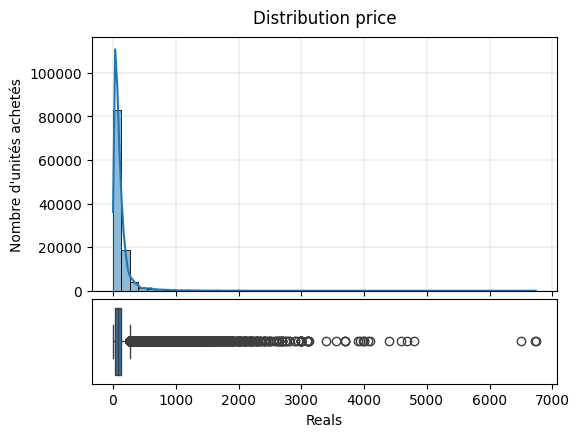

In [62]:
# Affichage histogramme et boxplot
plot_distribution(df_order_items, 'price', 'Reals', "Nombre d'unités achetés")

In [63]:
# Principales mesures statistiques
df_order_items['price'].to_frame().describe()

,price
count,110171.000000
mean,119.978937
std,182.315716
min,0.850000
25%,39.900000
50%,74.900000
75%,134.170000
max,6735.000000


> Sur la période 2016 - 2018, 1 euro valait entre 3.2326 réals au minimum et 4.9181 au maximum  
> *(Source : [exchange_rates.org](https://www.exchange-rates.org/fr/historique/eur-brl-2018))*

* Prix du produit le plus cher en euros

In [64]:
# Calcul du prix du produit le plus cher
high_price = df_order_items['price'].max()
print(f"Prix du produit le plus cher : {high_price}")
print(f"Soit entre {high_price // 4.9181} et {high_price // 3.2326} €")

Prix du produit le plus cher : 6735.0
Soit entre 1369.0 et 2083.0 €


* Le nom des produits n'étant pas disponible dans la BDD, peu de vérifications sont possibles
* Le montant maximum ne semble pas aberrant sur un site de vente en ligne, d'autant plus que la distribution montre un intervalle interquartile étroit, avec une médiane proche de 0

#### 2.2.2.4 `freight_value`

Frais de livraison unitaire d'un produit

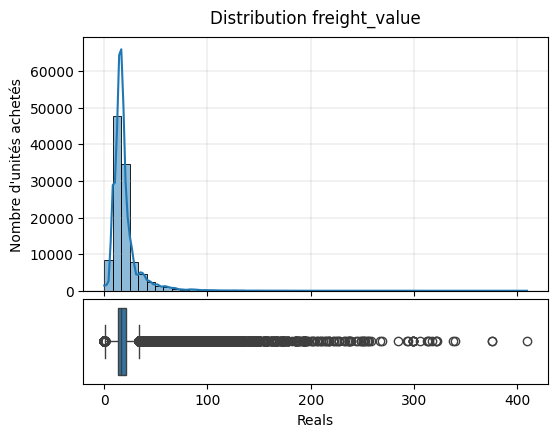

In [65]:
# Affichage histogramme et boxplot
plot_distribution(df_order_items, 'freight_value', 'Reals', "Nombre d'unités achetés")

In [66]:
# Principales mesures statistiques
df_order_items['freight_value'].to_frame().describe()

,freight_value
count,110171.000000
mean,19.948297
std,15.698675
min,0.000000
25%,13.080000
50%,16.260000
75%,21.150000
max,409.680000


* La distribution ressemble logiquement à celle de la variable `price`  
* Les montants son logiquement proportionnellement plus faibles

* Certaines commandes ont des frais de livraison à 0

In [67]:
# Affichage des commandes avec frais de livraison à 0
free_freight_value_mask = df_order_items['freight_value'] == 0
display(df_order_items.loc[free_freight_value_mask].sort_values('price'))

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
66445,97d6279a91ffe03ed63041acff508488,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-11 17:30:06,53.9,0.0
44679,6593a7ca55b089cc240f79d582e3300a,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-04-30 04:30:56,53.9,0.0
95991,d9cec2829cd4998f4d6ea00861d2a689,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-07 21:51:35,53.9,0.0
95992,d9cec2829cd4998f4d6ea00861d2a689,2,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-07 21:51:35,53.9,0.0
44571,654c6463f421d51939eae082dcc3b15e,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-04-23 16:30:18,53.9,0.0
...,...,...,...,...,...,...,...
99481,e1a73a8183d164944b0f44e1eb39ea7d,1,7a10781637204d8d10485c71a6108a2e,4869f7a5dfa277a7dca6462dcf3b52b2,2018-04-24 09:11:46,209.0,0.0
88163,c8310ae899dc9ca256b06db4c50d814c,1,7a10781637204d8d10485c71a6108a2e,4869f7a5dfa277a7dca6462dcf3b52b2,2018-04-24 19:12:26,209.0,0.0
12028,1b41edd8cc8fe751d98cba50338f8c8b,1,7a10781637204d8d10485c71a6108a2e,4869f7a5dfa277a7dca6462dcf3b52b2,2018-04-25 09:55:20,209.0,0.0
111497,fd4907109f6bac23f07064af84bec02d,1,7a10781637204d8d10485c71a6108a2e,4869f7a5dfa277a7dca6462dcf3b52b2,2018-04-30 11:31:32,219.0,0.0


In [68]:
percentage_of_rows = round((len(df_order_items.loc[free_freight_value_mask]) / df_order_items.shape[0]) * 100, 2)
print(f"{percentage_of_rows} % des lignes du dataframe sont concernées")

0.35 % des lignes du dataframe sont concernées


* Très peu de produits ont bénéficié d'un prix de livraison à 0
* L'observation des quelques exemples montre des `product_id` et `seller_id` identiques
* Il pourrait s'agir de promotions sur certains produits et/ou des offres de certains vendeurs  
* La livraison gratuite est une pratique commerciale courante
* Rien d'inquiétant

### 2.2.3 Table `order_pymts`

In [69]:
# Récupération de tout le contenu de la table dans un dataframe
df_order_pymts = f_query_result("SELECT * FROM order_pymts;").drop('index', axis=1)

In [70]:
# Description des champs de la table
display(describe_table('order_pymts'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,TEXT,99440,4446,0,0.0 %
1,payment_sequential,BIGINT,29,103857,0,0.0 %
2,payment_type,TEXT,5,103881,0,0.0 %
3,payment_installments,BIGINT,24,103862,0,0.0 %
4,payment_value,FLOAT,29077,74809,0,0.0 %


In [71]:
# Description des variables du dataframe
display(get_dataframe_infos(df_order_pymts))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,99440,4446,0,0.0 %
1,payment_sequential,int64,29,103857,0,0.0 %
2,payment_type,object,5,103881,0,0.0 %
3,payment_installments,int64,24,103862,0,0.0 %
4,payment_value,float64,29077,74809,0,0.0 %


* Hormis les types, les informations relevées sont strictement identiques👍🏼
* Aucune valeur n'est manquante👍🏼
* Les variables `order_id`, et `payment_type` doivent être converties dans les bons types

* Suppression des commandes supprimées précédemment de `df_orders`

In [72]:
# Récupération des 'order_id' de la table 'orders'
valid_order_ids = df_orders['order_id'].unique()

In [73]:
# Filtre sur les 'order_id' valides
valid_orders_mask = df_order_pymts['order_id'].isin(valid_order_ids)

In [74]:
# Suppression des lignes de 'df_order_pymts' ne correspondant pas à une commande valide dans 'df_orders'
df_order_pymts = df_order_pymts.loc[valid_orders_mask]

* Transformation des types de données

In [75]:
# Dictionnaire de conversion
to_transform = {'to_string': ['order_id', 'payment_type']}

# Conversions
df_order_pymts = transform_data_types(df_order_pymts, to_transform)

In [76]:
# Vérification des conversions
display(get_dataframe_infos(df_order_pymts))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,96453,4279,0,0.0 %
1,payment_sequential,int64,26,100706,0,0.0 %
2,payment_type,category,4,100728,0,0.0 %
3,payment_installments,int64,24,100708,0,0.0 %
4,payment_value,float64,28542,72190,0,0.0 %


In [77]:
# Affichage de quelques lignes
display(df_order_pymts)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103879,c45067032fd84f4cf408730ff5205568,1,credit_card,2,198.94
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


#### 2.2.3.1 `payment_type`

Cette variable indique le moyen de paiement utilisé

* Valeurs uniques

In [78]:
# Répartition des moyens de paiement utilisés
dft = df_order_pymts['payment_type'].value_counts().to_frame()
number_of_rows = df_order_pymts.shape[0]
dft['%'] = round((dft['count'] / number_of_rows) * 100, 2)
dft = dft.reset_index()
display(dft)

,payment_type,count,%
0,credit_card,74577,74.04
1,boleto,19177,19.04
2,voucher,5493,5.45
3,debit_card,1485,1.47


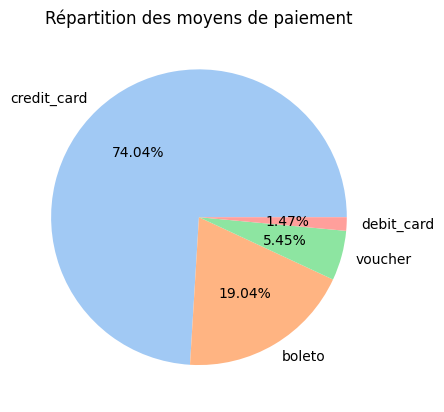

In [79]:
# Répartition des moyens de paiement utilisés
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des moyens de paiement')
plt.pie(dft['count'], labels=dft['payment_type'], colors = colors, autopct='%.2f%%')
plt.show()

* Attention, si on peut raisonablement estimer que la grande majorité des commandes sont réglées par CB, les pourcentages concernent les **réglements** et non les commandes.
* En effet, une commande peut être payée en plusieurs fois et avec plusieurs moyens de règlement
* Exemple de la commande d'`order_id` 'ccf804e764ed5650cd8759557269dc13' :

In [80]:
mask = df_order_pymts['order_id'] == 'ccf804e764ed5650cd8759557269dc13'
df_order_pymts.loc[mask]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
4346,ccf804e764ed5650cd8759557269dc13,19,voucher,1,1.68
14362,ccf804e764ed5650cd8759557269dc13,1,credit_card,1,2.20
16279,ccf804e764ed5650cd8759557269dc13,14,voucher,1,0.97
18876,ccf804e764ed5650cd8759557269dc13,15,voucher,1,1.11
21447,ccf804e764ed5650cd8759557269dc13,6,voucher,1,2.26
32393,ccf804e764ed5650cd8759557269dc13,26,voucher,1,23.10
38001,ccf804e764ed5650cd8759557269dc13,2,voucher,1,1.45
39132,ccf804e764ed5650cd8759557269dc13,25,voucher,1,1.53
40369,ccf804e764ed5650cd8759557269dc13,5,voucher,1,2.69
40387,ccf804e764ed5650cd8759557269dc13,3,voucher,1,1.15


#### 2.2.3.2 `payment_sequential`

Cette variable identifie le nombre de méthodes de paiement utilisées pour une seule commande  
   * Le client peut utiliser une méthode de paiement différent pour chaque échéance s'il paye en plusieurs fois
   * Chaque voucher est considéré comme un moyen de paiement différent (voir exemple précédent)

* Valeurs uniques

In [81]:
# récupération du nombre de méthodes de paiement par commande
dft = df_order_pymts.groupby('order_id').agg(
    number_of_payment_methods = ('payment_sequential', 'max')
).reset_index()

In [82]:
dft2 = dft['number_of_payment_methods'].value_counts().to_frame()
total = dft2['count'].sum()
dft2['%'] = (dft2['count'] / total) * 100
dft2 = dft2.reset_index()
display(dft2)

,number_of_payment_methods,count,%
0,1,93502,96.940479
1,2,2387,2.474780
2,3,297,0.307922
3,4,104,0.107825
4,5,52,0.053912
5,6,35,0.036287
6,7,28,0.029030
7,8,10,0.010368
8,11,8,0.008294
9,12,8,0.008294


* La grande majorité des commandes (environ **97 %**) sont payées avec **1 seule méthode de règlement**  
* Seulement environ **2,5 %** des commandes sont payées en **2 méthode de réglement**  
* Environ **0,6 %** des commandes sont payées avec **3 méthodes de règlement ou plus**
* La commande montré en exemple précédemment a été réglée avec **26 méthodes différentes**  

#### 2.2.3.3 `payment_installments`

Nombre d'échéances choisies par le client pour payer une commande

* Valeurs uniques

In [83]:
# récupération du nombre d'échéances par commande
dft = df_order_pymts.groupby('order_id').agg(
    number_of_installments = ('payment_installments', 'max')
).reset_index()

In [84]:
dft2 = dft['number_of_installments'].value_counts().to_frame()
total = dft2['count'].sum()
dft2['%'] = (dft2['count'] / total) * 100
dft2 = dft2.reset_index().sort_values('number_of_installments')
display(dft2)

,number_of_installments,count,%
21,0,2,0.002074
0,1,46796,48.516894
1,2,12026,12.468249
2,3,10131,10.503561
3,4,6862,7.114346
5,5,5082,5.268887
7,6,3792,3.931448
8,7,1559,1.616331
6,8,4120,4.271510
9,9,618,0.640727


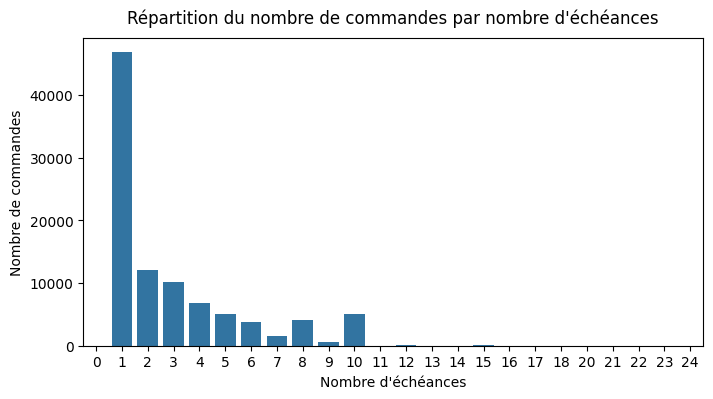

In [85]:
# Barplot de répartition 
plt.figure(figsize=(8, 4))
sns.barplot(data=dft2, x='number_of_installments', y='count')
plt.title('Répartition du nombre de commandes par nombre d\'échéances', pad=10)
plt.xlabel('Nombre d\'échéances')
plt.ylabel('Nombre de commandes')
plt.show()

In [86]:
# Calcul du pourcentage de commandes payées avec un nombre d'échéances compris entre 2 et 10
mask = (dft2['number_of_installments'] >= 2) & ((dft2['number_of_installments'] <= 10))
percentage = round(dft2.loc[mask, '%'].sum(), 2)
print(f"{percentage} % des commandes sont payées avec un nombre d'échéances compris entre 2 et 10")

51.14 % des commandes sont payées avec un nombre d'échéances compris entre 2 et 10


* Le nombre d'échéances va de **0** à **24** : quelles commandes ont 0 échéance ?
* **48,5 %** des commandes n'ont pas fait l'objet d'un échéancier (règlement en 1 fois)
* **51.14 %** des commandes sont payées avec un nombre d'échéances compris entre 2 et 10

* Quelles sont les commandes avec un nombre d'échéances à 0 ?

In [87]:
no_payment_installments_mask = df_order_pymts['payment_installments'] == 0
no_payment_installments_order_ids = df_order_pymts.loc[no_payment_installments_mask, 'order_id'].to_list()
display(df_order_pymts.loc[no_payment_installments_mask])

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,0,58.69
79014,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,0,129.94


* Il s'agit probablement d'une erreur de saisie

In [88]:
# Correction
df_order_pymts.loc[no_payment_installments_mask, 'payment_installments'] = 1

In [89]:
# Affichage des commandes concernées pour vérification
display(df_order_pymts.loc[no_payment_installments_mask])

,order_id,payment_sequential,payment_type,payment_installments,payment_value
46982,744bade1fcf9ff3f31d860ace076d422,2,credit_card,1,58.69
79014,1a57108394169c0b47d8f876acc9ba2d,2,credit_card,1,129.94


### 2.2.4 Table `order_reviews`

In [108]:
# Récupération de tout le contenu de la table dans un dataframe
df_order_reviews = f_query_result("SELECT * FROM order_reviews;").drop('index', axis=1)

In [109]:
# Description des champs de la table
display(describe_table('order_reviews'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,review_id,TEXT,98410,814,0,0.0 %
1,order_id,TEXT,98673,551,0,0.0 %
2,review_score,BIGINT,5,99219,0,0.0 %
3,review_comment_title,TEXT,4527,7041,87656,88.34 %
4,review_comment_message,TEXT,36159,4818,58247,58.7 %
5,review_creation_date,TEXT,636,98588,0,0.0 %
6,review_answer_timestamp,TEXT,98248,976,0,0.0 %


In [110]:
# Description des variables du dataframe
display(get_dataframe_infos(df_order_reviews))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,review_id,object,98410,814,0,0.0 %
1,order_id,object,98673,551,0,0.0 %
2,review_score,int64,5,99219,0,0.0 %
3,review_comment_title,object,4527,7041,87656,88.34 %
4,review_comment_message,object,36159,4818,58247,58.7 %
5,review_creation_date,object,636,98588,0,0.0 %
6,review_answer_timestamp,object,98248,976,0,0.0 %


* Hormis les types, les informations relevées sont strictement identiques👍🏼
* **88 %** de `review_comment_title` et **59 %** de `review_comment_message` sont manquants
* Les variables doivent être converties dans les bons types

* Suppression des commandes supprimées précédemment de `df_orders`

In [111]:
# Récupération des 'order_id' de la table 'orders'
valid_order_ids = df_orders['order_id'].unique()

In [112]:
# Filtre sur les 'order_id' valides
valid_orders_mask = df_order_reviews['order_id'].isin(valid_order_ids)

In [113]:
# Suppression des lignes de 'df_order_pymts' ne correspondant pas à une commande valide dans 'df_orders'
df_order_reviews = df_order_reviews.loc[valid_orders_mask]

* Transformation des types de données

In [114]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['review_id', 'order_id','review_comment_title', 'review_comment_message'],
    'to_date': ['review_creation_date', 'review_answer_timestamp']
}

# Conversions
df_order_reviews = transform_data_types(df_order_reviews, to_transform)

In [115]:
# Vérification des conversions
display(get_dataframe_infos(df_order_reviews))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,review_id,object,95623,714,0,0.0 %
1,order_id,object,95808,529,0,0.0 %
2,review_score,int64,5,96332,0,0.0 %
3,review_comment_title,object,4364,6840,85133,88.37 %
4,review_comment_message,object,34429,4658,57250,59.43 %
5,review_creation_date,datetime64[ns],627,95710,0,0.0 %
6,review_answer_timestamp,datetime64[ns],95470,867,0,0.0 %


In [116]:
# Affichage de quelques lignes
display(df_order_reviews)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01,2018-07-02 12:59:13


#### 2.2.4.1 `review_score`

Cette variable indique la note de satisfaction (de 1 à 5) donnée par l'acheteur, en réponse à une enquête de satisfaction

* Pourcentage de commandes évaluées

In [117]:
# Pourcentage de commandes évaluées
number_of_orders = df_orders['order_id'].nunique()
number_of_evaluated_orders = df_order_reviews['order_id'].nunique()
print(f"Environ {round((number_of_evaluated_orders / number_of_orders) * 100)} % des commandes ont été évaluées par les acheteurs.")

Environ 99 % des commandes ont été évaluées par les acheteurs.


* Répatition des scores

In [118]:
# Répartition des review_score
dft = df_order_reviews['review_score'].value_counts().to_frame()
number_of_rows = df_order_reviews.shape[0]
dft['%'] = round((dft['count'] / number_of_rows) * 100, 2)
dft = dft.reset_index()
display(dft)

,review_score,count,%
0,5,57049,59.22
1,4,18983,19.70
2,1,9405,9.76
3,3,7960,8.26
4,2,2940,3.05


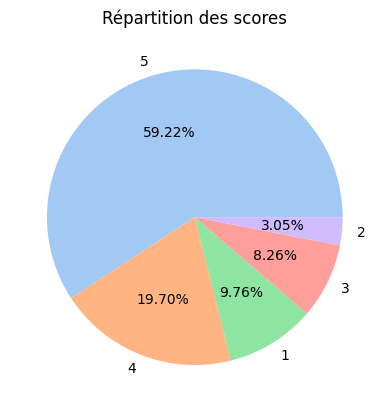

In [119]:
# Répartition des scores
colors = sns.color_palette('pastel')[0:5]
plt.title('Répartition des scores')
plt.pie(dft['count'], labels=dft['review_score'], colors = colors, autopct='%.2f%%')
plt.show()

***Cette répartition ne tient compte que des commandes évaluées***

#### 2.2.4.2 `review_comment_title`, `review_comment_message`

Titres et commentaires de notation

* Affichage de quelques exemples

In [121]:
mask = (df_order_reviews['review_comment_title'].notna()) & (df_order_reviews['review_comment_message'].notna())
display(df_order_reviews.loc[mask])

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23,2018-05-24 03:00:01
22,d21bbc789670eab777d27372ab9094cc,4fc44d78867142c627497b60a7e0228a,5,Ótimo,Loja nota 10,2018-07-10,2018-07-11 14:10:25
34,c92cdd7dd544a01aa35137f901669cdf,37e7875cdce5a9e5b3a692971f370151,4,Muito bom.,Recebi exatamente o que esperava. As demais en...,2018-06-07,2018-06-09 18:44:02
36,08c9d79ec0eba1d252e3f52f14b8e6a9,e029f708df3cc108b3264558771605c6,5,Bom,"Recomendo ,",2018-06-13,2018-06-13 22:54:44
...,...,...,...,...,...,...,...
99187,47e0954e156dac6512c25c6d2ecc1c66,16cbf959cfdb88c47ee2a29303547ec2,5,Nota máxima!,"Muito obrigado,\r\n\r\nExcelente atendimento,b...",2018-05-22,2018-05-23 00:51:43
99192,0e7bc73fde6782891898ea71443f9904,bd78f91afbb1ecbc6124974c5e813043,4,👍,Aprovado!,2018-07-04,2018-07-05 00:25:13
99196,58be140ccdc12e8908ff7fd2ba5c7cb0,0ebf8e35b9807ee2d717922d5663ccdb,5,muito bom produto,"Ficamos muito satisfeitos com o produto, atend...",2018-06-30,2018-07-02 23:09:35
99197,51de4e06a6b701cb2be47ea0e689437b,b7467ae483dbe956fe9acdf0b1e6e3f4,3,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,2018-06-05,2018-06-06 10:52:19


* Les titres et commentaires sont libres et en portugais
* Ces variables ne seront pas utilisées  

#### 2.2.4.3 `review_creation_date`, `review_answer_timestamp`

Date d'envoi de l'enquête de satisfaction, date et heure de réponse à l'enquête par le client

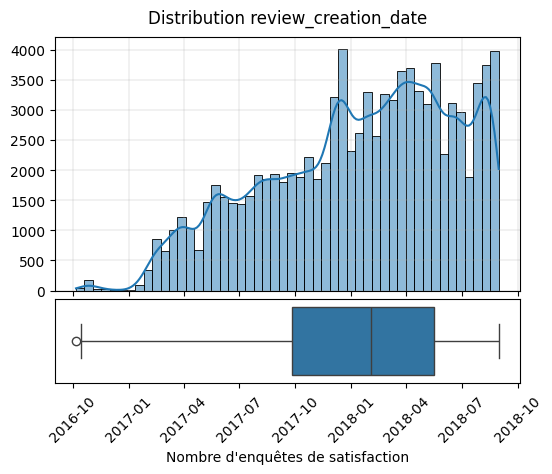

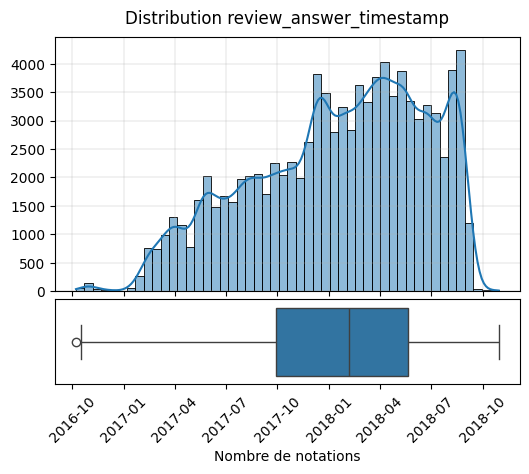

In [122]:
# Affichage des distibutions
plot_distribution(df_order_reviews, 'review_creation_date', 'Nombre d\'enquêtes de satisfaction', '', x_tick_angle=45)
plot_distribution(df_order_reviews, 'review_answer_timestamp', 'Nombre de notations', '', x_tick_angle=45)

## 2.3 Analyses bivariées

> * Vérifier les relations entre tables : tous les `orders.order_id` ont-ils un `customers.customer_id` correspondant ? ... ... ...